# Notebook for results analysis of GAN training. 

In [1]:
#Import of necessary packages and memory allocation.
%matplotlib inline

import tensorflow as tf
import keras 
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = str(1)
set_session(tf.Session(config=config))
import time
import h5py as h5
import pandas as pd
from keras.models import load_model
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

import sys
import seaborn as sns
import math
from sklearn.decomposition import PCA
#s = np.random.seed(1)

Using TensorFlow backend.


In [2]:

import cartopy
import cartopy.crs as ccrs
import cartopy.util

In [3]:
#Plot parameters
sns.set() #Seaborn theme 

from matplotlib import rc
font = {'family' : 'normal','weight' : 'bold', 'size'   : 22}
tick_size = 20
fontweight = 'bold'
#lab_loc = 2
#lab_font_size = 14
#rc('text', usetex=True)
matplotlib.rc('font', **font)
plt.style.use('seaborn')

## Path managment

folderpath is the folder in which you cloned the github repository


In [4]:
data_folder = '../../Puma_Project/data/raw/'
model_path = '../model/RESNET_V8_82l_continue4_generator.h5'

## Parameters. 

Setting up parameters for figure generations 

In [5]:
#########
plot_var = True    #True: plot all cells result ; False : manualy change if plot_var in if True: to plot
save = False         
scale = False
#########
N_fields = 82      #Number of fields == Number of channels in generated tensor. 
N_lvls = 10         #Number of pressure level for 3D variable. 

years = 1
N_train = 360*years
N_gen = 360*years     #Number of generation used for statistic analysis /!\ Memory usage important /!\
scaled = False


In [6]:
# Creation of channel list
if N_fields==82:
    var = ['ta', 'ua', 'va', 'hus', 'wap', 'zeta', 'd', 'zg']
    lvls = [100, 200,300,400,500,600,700,800,900,1000]

chan_titles = [i+'_z'+str(j) for i in var for j in lvls]
chan_titles.append('surf_press')
chan_titles.append('latitudes')
print(chan_titles)
print(len(chan_titles))

['ta_z100', 'ta_z200', 'ta_z300', 'ta_z400', 'ta_z500', 'ta_z600', 'ta_z700', 'ta_z800', 'ta_z900', 'ta_z1000', 'ua_z100', 'ua_z200', 'ua_z300', 'ua_z400', 'ua_z500', 'ua_z600', 'ua_z700', 'ua_z800', 'ua_z900', 'ua_z1000', 'va_z100', 'va_z200', 'va_z300', 'va_z400', 'va_z500', 'va_z600', 'va_z700', 'va_z800', 'va_z900', 'va_z1000', 'hus_z100', 'hus_z200', 'hus_z300', 'hus_z400', 'hus_z500', 'hus_z600', 'hus_z700', 'hus_z800', 'hus_z900', 'hus_z1000', 'wap_z100', 'wap_z200', 'wap_z300', 'wap_z400', 'wap_z500', 'wap_z600', 'wap_z700', 'wap_z800', 'wap_z900', 'wap_z1000', 'zeta_z100', 'zeta_z200', 'zeta_z300', 'zeta_z400', 'zeta_z500', 'zeta_z600', 'zeta_z700', 'zeta_z800', 'zeta_z900', 'zeta_z1000', 'd_z100', 'd_z200', 'd_z300', 'd_z400', 'd_z500', 'd_z600', 'd_z700', 'd_z800', 'd_z900', 'd_z1000', 'zg_z100', 'zg_z200', 'zg_z300', 'zg_z400', 'zg_z500', 'zg_z600', 'zg_z700', 'zg_z800', 'zg_z900', 'zg_z1000', 'surf_press', 'latitudes']
82


In [15]:
#########
lons = np.genfromtxt(f'../data/raw/lon.csv', delimiter=',')
lat = np.genfromtxt(f'../data/raw/lat.csv', delimiter=',')


lon_idx = [16,16,32,48]                    #France, north america, ecuador, south america
lat_idx = [5,106,106,106]                  #France, north america, ecuador, south america
fnes = [[16,5],[16,106],[32,106],[48,106]] #Coordinate for distribution comparison at different locations.
L_ind = ['a','b','c','d']

#Loading dataset and scaling factors (N_fields, 2)= mean and variance for each channel.
if N_fields==82:
    f=h5.File(f'{data_folder}T42_plasim_100y_10lay_scaled.h5','r')
    _X_train = f['dataset']
    scaling = np.transpose(f['scaling'])


print(scaling.shape)

(81, 2)


## Loads dataset samples and generates sample from the generator

The following cell is loading the trained generator, generates samples (same number as samples loaded in the dataset '*years*' parameter define above), scales the generation and the dataset if the flag defined above is True.

In [16]:
if N_fields==82:
    runnumber_4, stop4 = 'RESNET_V8_82l_continue4', 31000
    runnumber = runnumber_4 #Most recent save


import random
sys.path.append('../scripts/')
indexes = random.sample(range(0,_X_train.shape[0]), N_train)
from SpectralNormalizationKeras import *
from custom_classes import *
#from data_preproc import *

try:
    gen = load_model(f'../GAN_model/{runnumber}/{runnumber}_generator.h5',custom_objects = {'NearestPadding2D': NearestPadding2D,'WrapPadding2D': WrapPadding2D, 'DenseSN' :DenseSN, 'ConvSN2D': ConvSN2D})
except:
    gen = load_model(f'../GAN_model/{runnumber}_generator.h5',
          custom_objects = {'NearestPadding2D': NearestPadding2D,'WrapPadding2D': WrapPadding2D, 'DenseSN' :DenseSN, 'ConvSN2D': ConvSN2D})
gen._make_predict_function()


print('Generating samples...')

z = np.random.normal(0,1,(N_gen,64))
fk_imgs = gen.predict(z)
print('Samples generated.')
print('scaling...')
if scaled:
    fk_imgs = np.multiply(fk_imgs[:,:,:,:-1],
                          scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('scaled.')
print('Database loading...')

if N_fields==82:
    f=h5.File(f'{dbPath}T42_plasim_100y_10lay_scaled.h5','r')
    _X_train = f['dataset']
    scaling = np.transpose(f['scaling'])
    
print('Database loaded.')

print('Scaling...')
if scaled:
    X_train = np.multiply(_X_train[np.sort(indexes),:,:,:],
                          scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
else:
    X_train = _X_train[:N_train]
print('Scaled')

#noise_ = np.load('./fig_82c/noise_.npy')
#im = gen.predict(noise_)
#im_sc = np.multiply(im[:,:,:,:-1],
#                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]




/softs/anaconda3/envs/tf1.12-cuda10-py36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Generating samples...
Samples generated.
scaling...
scaled.
Database loading...
Database loaded.
Scaling...
Scaled


In [18]:
#Creates the lattitudes fields in order to concatenate it to the database (as it was done during the WGAN training).

from mpl_toolkits.axes_grid1 import make_axes_locatable

lon=lons
lat=lats
#llat = np.load('../data/raw/llat.npy')
#lat = np.arange(-1,1,2./64.).reshape(64)
llat = np.expand_dims(lat, axis = 0)
llat = np.expand_dims(llat, axis = -1)
llat = llat.repeat(N_train, axis = 0)
llat = llat.repeat(128, axis = 2)


In [19]:
# which field to choose
field = 74
#Component to keep
Nc = 5

In [27]:
X = X_train[:,:,:,field]
Xg = fk_imgs[:,:,:,field]

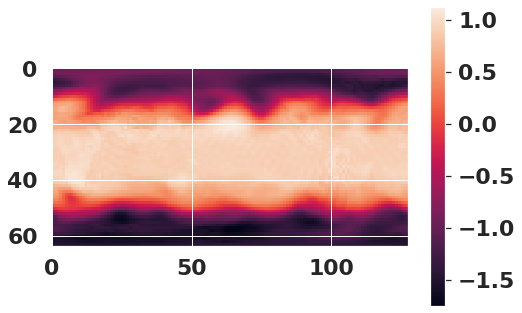

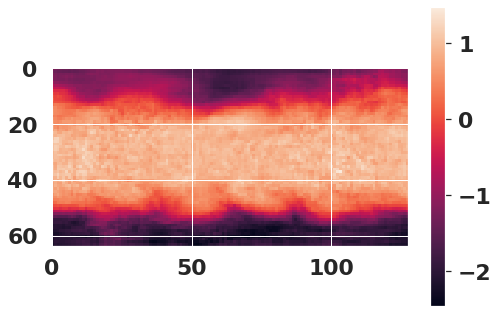

In [28]:
plt.figure()
plt.imshow(X[0,:,:])
plt.colorbar()

plt.figure()
plt.imshow(Xg[0,:,:])
plt.colorbar()

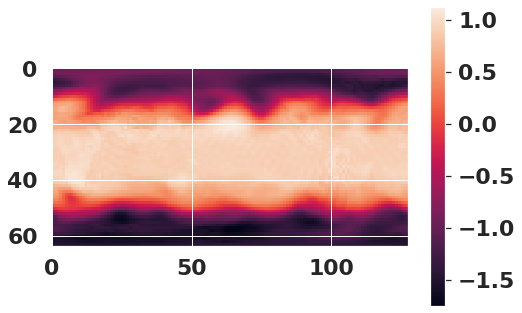

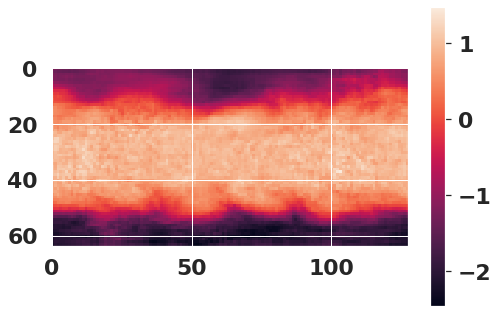

In [29]:
#X = (X - meanX)/stdX
#Xg = (Xg - meanXg)/stdXg

plt.figure()
plt.imshow(X[0,:,:])
plt.colorbar()

plt.figure()
plt.imshow(Xg[0,:,:])
plt.colorbar()

[[-0.97008753 -0.9689281  -0.96782672 ... -1.45743024 -1.46105993
  -1.4646343 ]
 [-0.8356303  -0.83683318 -0.83817041 ... -1.44912088 -1.45215511
  -1.45512331]
 [-0.80723196 -0.80800265 -0.80879843 ... -1.44583642 -1.44996274
  -1.45400476]
 ...
 [-0.90362567 -0.90621984 -0.90874147 ... -1.89955568 -1.9076041
  -1.91585946]
 [-0.89854676 -0.900635   -0.90263492 ... -1.89025819 -1.89426458
  -1.8985306 ]
 [-0.8894456  -0.89109904 -0.89262867 ... -1.82084513 -1.82667637
  -1.832551  ]]
####### SVD on dataset #######
[ 17.7486953  809.87281786  25.84935863  18.96293224  14.40086535]
0.7657416927204146
[3556.11390562 1207.38437179  215.75863766  184.88294157  161.00199421]
####### SVD on generated data #######
[ 28.77964  780.6552    32.081722  23.866367  19.62169 ]
0.7361595
[3612.1118  1185.6206   240.5618   207.27051  188.01744]


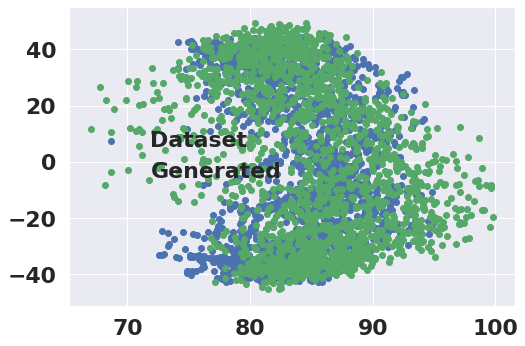

In [30]:
A = X.reshape(N_train,64*128)
Ag = Xg.reshape(N_gen,64*128)
from numpy import array
from sklearn.decomposition import TruncatedSVD
# define array
print(A)
# svd
svd = TruncatedSVD(n_components=Nc)
svd.fit(A)
At = svd.transform(A)

svdg = TruncatedSVD(n_components=Nc)
svdg.fit(Ag)
Agt = svdg.transform(Ag)




print('####### SVD on dataset #######')
print(svd.explained_variance_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)
print('####### SVD on generated data #######')
print(svdg.explained_variance_)
print(svdg.explained_variance_ratio_.sum())
print(svdg.singular_values_)

Ar = svd.inverse_transform(At).reshape(X.shape)


Agr = svdg.inverse_transform(Agt).reshape(Xg.shape)


compo1 = 0
compo2 = 1
plt.figure()
plt.scatter(At[:,compo1], At[:,compo2], color='b')
plt.scatter(Agt[:,compo1], Agt[:,compo2], color='g')
plt.legend(['Dataset', 'Generated'])


In [31]:
dfd = pd.DataFrame(At, columns=[f'Component{i}' for i in range(Nc)])
dfd['parameter'] = 'dataset'
dfd['line_color'] = 'y'
dfg = pd.DataFrame(Agt, columns=[f'Component{j}' for j in range(Nc)])
dfg['parameter'] = 'generated'
dfg['line_color'] = 'k'

dfg.head()
frames = [dfd,dfg]

df = pd.concat(frames)
print(df['line_color'].values)
df.head()

['y' 'y' 'y' ... 'k' 'k' 'k']


,Component0,Component1,Component2,Component3,Component4,parameter,line_color
0,83.751583,-9.560400,-1.944804,-1.792604,4.445365,dataset,y
1,83.216376,-10.559762,-1.661829,-2.850478,4.528555,dataset,y
2,82.890772,-12.486116,-1.940920,-3.712513,4.700626,dataset,y
3,82.809973,-13.345294,-1.755822,-3.332509,3.135943,dataset,y
4,82.187128,-14.184541,-2.995764,-2.170398,3.401461,dataset,y


AxesSubplot(0.1,0.786626;0.164815x0.163374)


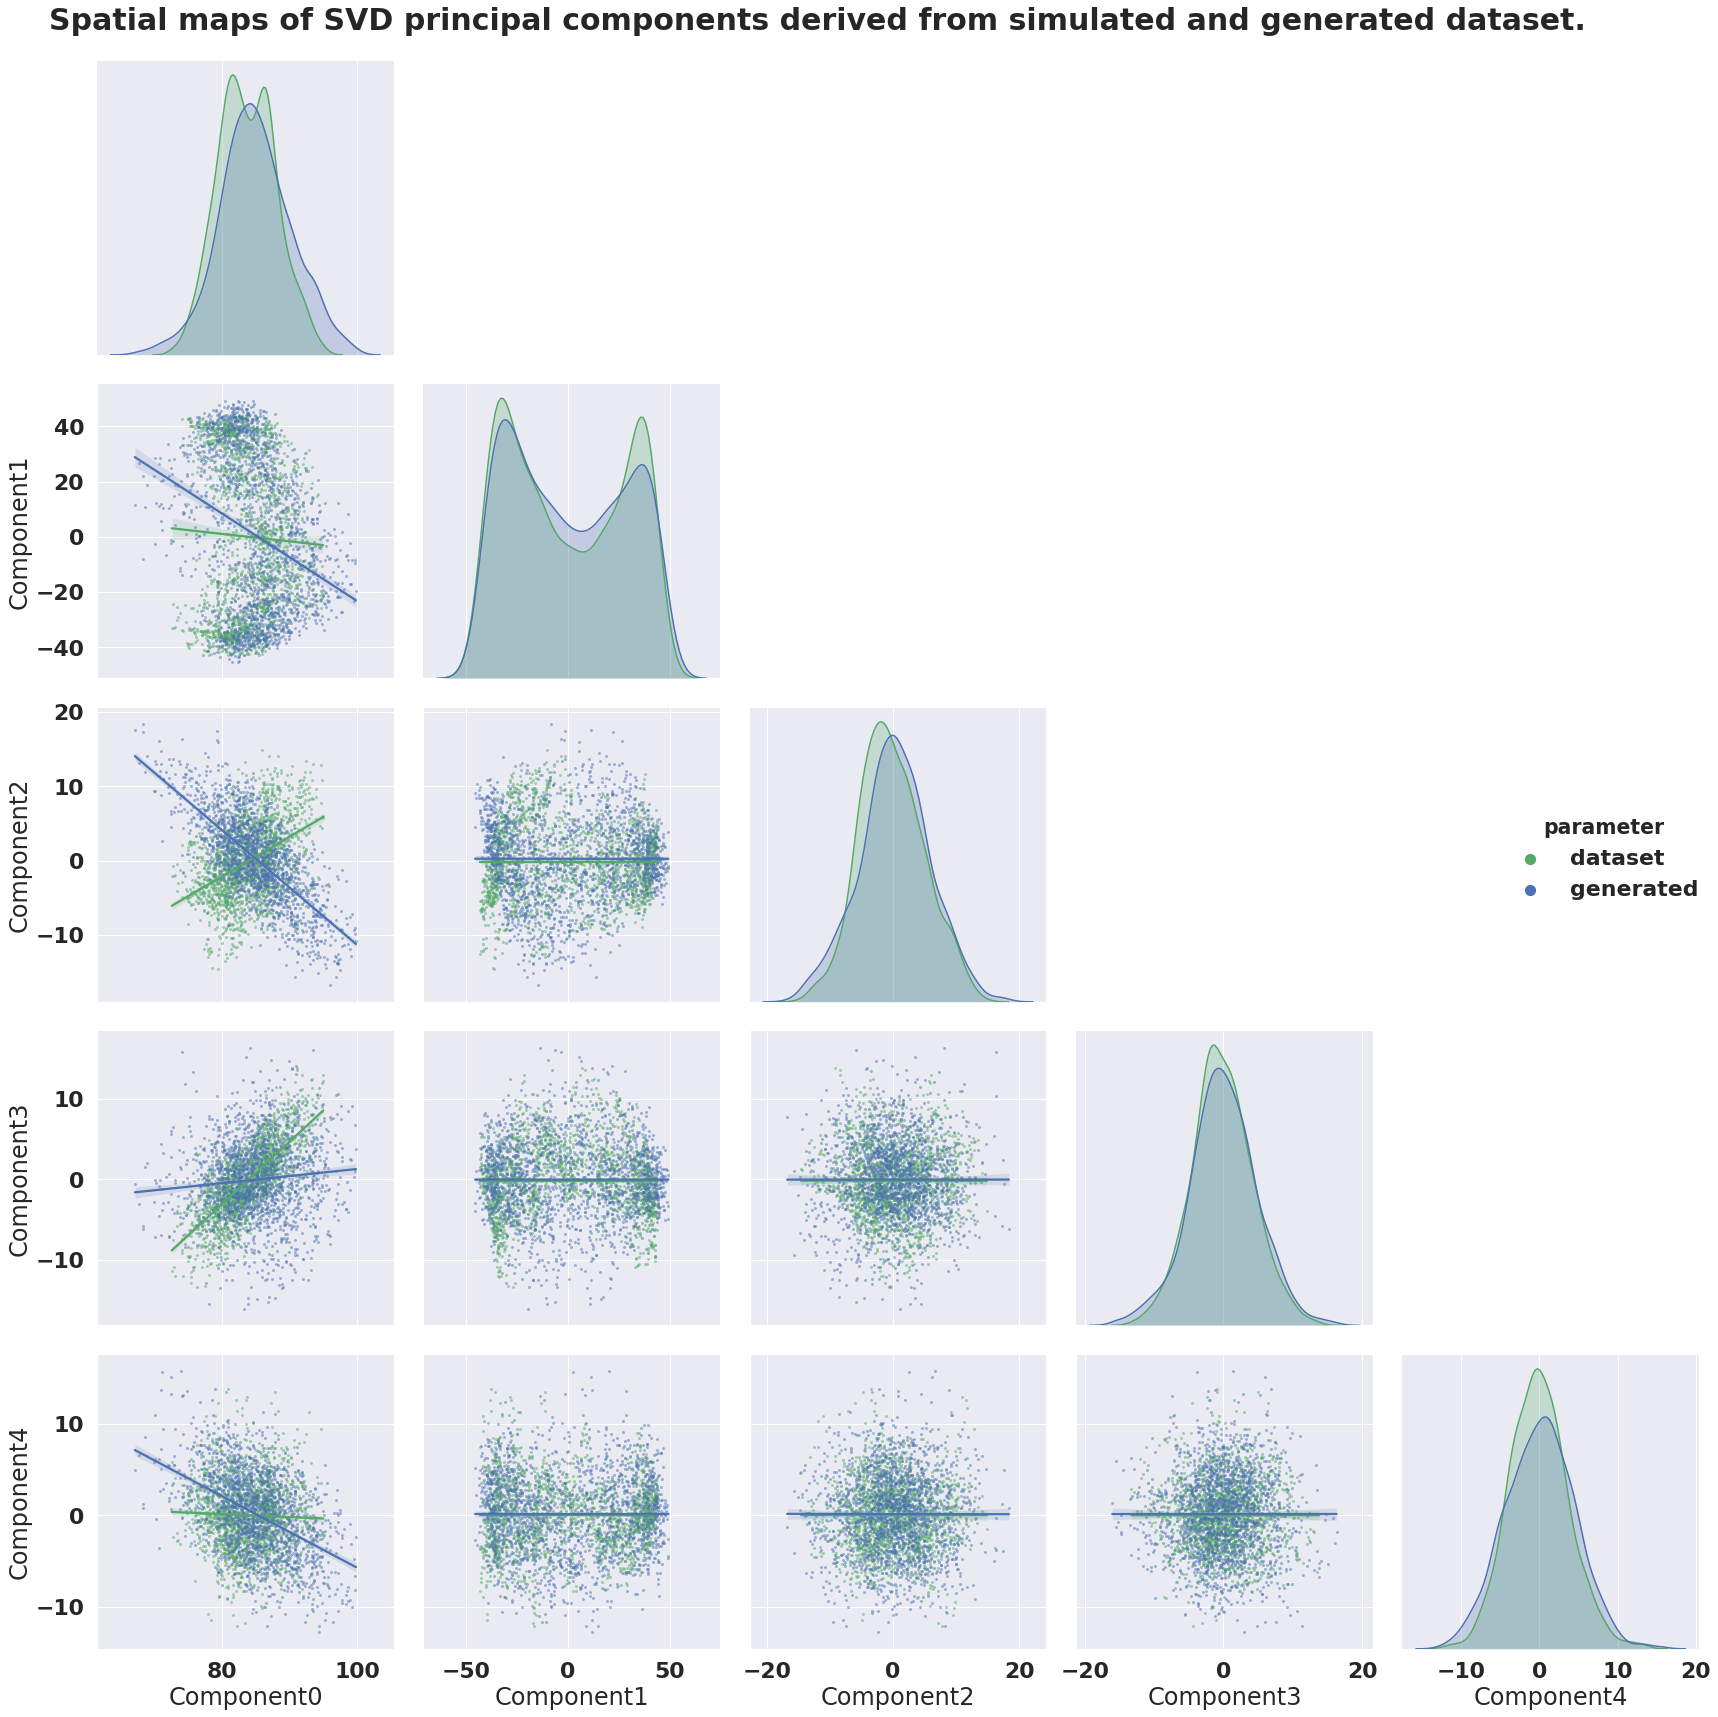

In [32]:
sns.set(font_scale = 2)

g = sns.pairplot(df, hue='parameter', markers='.', kind='reg', corner=True, palette=['g','b'],
                 plot_kws={'scatter_kws': {'alpha': .5}})
g.fig.subplots_adjust(top=0.95,right=0.99, left=0.1, wspace=0.1, hspace=0.1)
g.fig.suptitle(f'Spatial maps of SVD principal components derived from simulated and generated dataset.\n'
               , fontsize=30, fontweight='bold')
g.fig.set_size_inches(25,25)
c=0
cnt=0
pascalcnt=0
print(g.fig.axes[0])
print(g.axes[-1,:])

xlabels = ['Component0']
ax = g.axes[0,0]
ylabel = ax.yaxis.get_label_text()
#xlabels.append(xlabel)

for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [500]

g.axes[0,0].yaxis.set_label_text(xlabels[0])

if save:
    plt.savefig('./fig_82c/SVD_on_data_and_generated_compo_proj_30y.pdf')


In [33]:
print(g.fig.axes[0])
print(g.axes[0,:])

AxesSubplot(0.1,0.786626;0.164815x0.163374)
[<matplotlib.axes._subplots.AxesSubplot object at 0x2b4a4b63a438> None
 None None None]


In [34]:
print(dir(g.fig.axes[0]))
for ax in g.fig.axes:
    if len(ax.get_lines()) != 0:
        print(ax.get_lines())


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_text', '_adjustable', '_agg_filter', '_alpha', '_anchor', '_animated', '_aspect', '_autoscaleXon', '_autoscaleYon', '_autotitlepos', '_axes', '_axes_class', '_axes_locator', '_axisbelow', '_clipon', '_clippath', '_connected', '_contains', '_convert_dx', '_current_image', '_facecolor', '_frameon', '_gci', '_gen_axes_patch', '_gen_axes_spines', '_get_axis_list', '_get_clipping_extent_bbox', '_get_lines', '_get_patches_for_fill', '_get_view', '_gid', '_gridOn', '_in_layout', '_init_axis', '_label', '_layoutbox', '_left_title', '_make_twin_axes', '_mouseover', '_mouseover_set', '_navigate', '_navigate_mode', '_oid

Text(0.5, 0.98, 'Spatial maps of SVD principal components derived from simulated and generated dataset.\n')

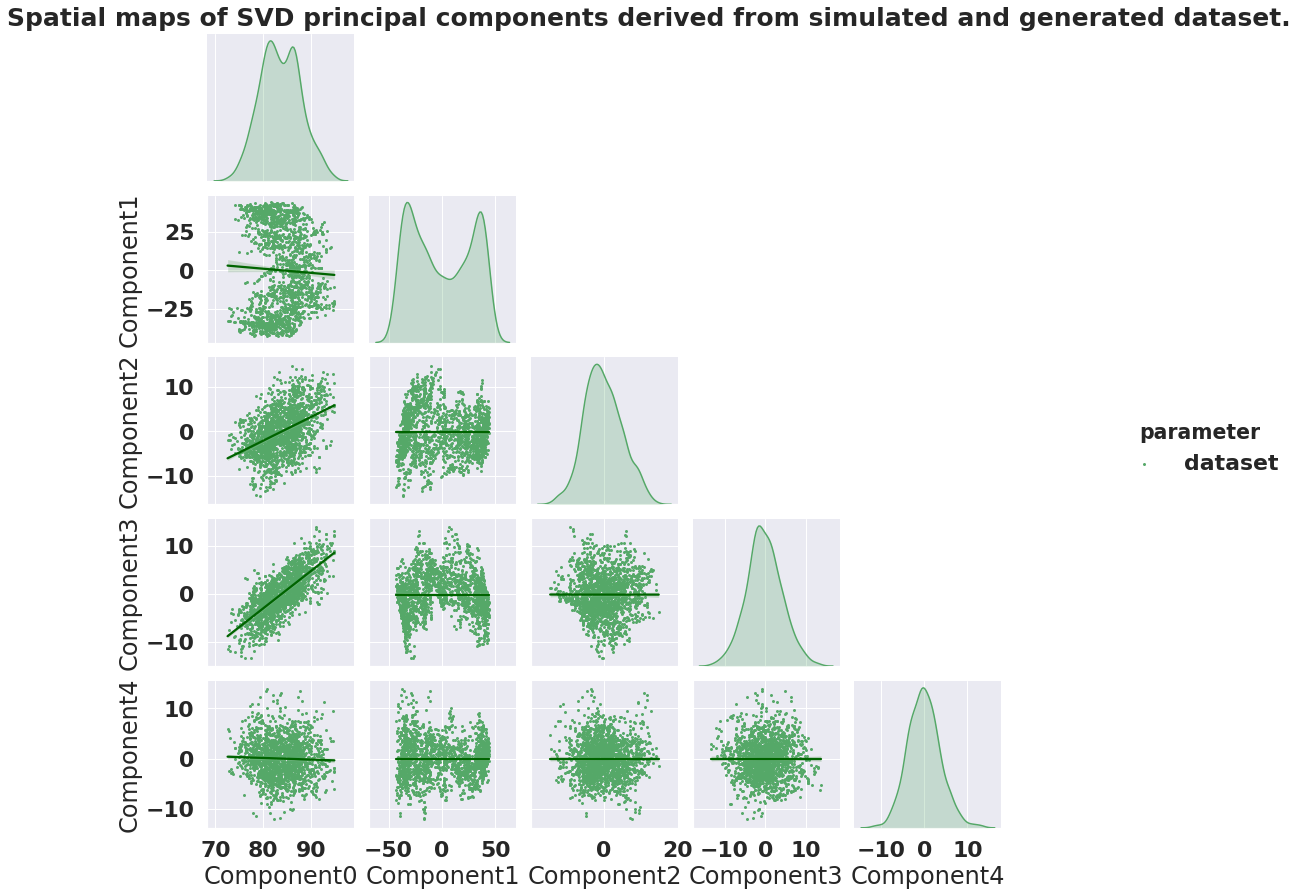

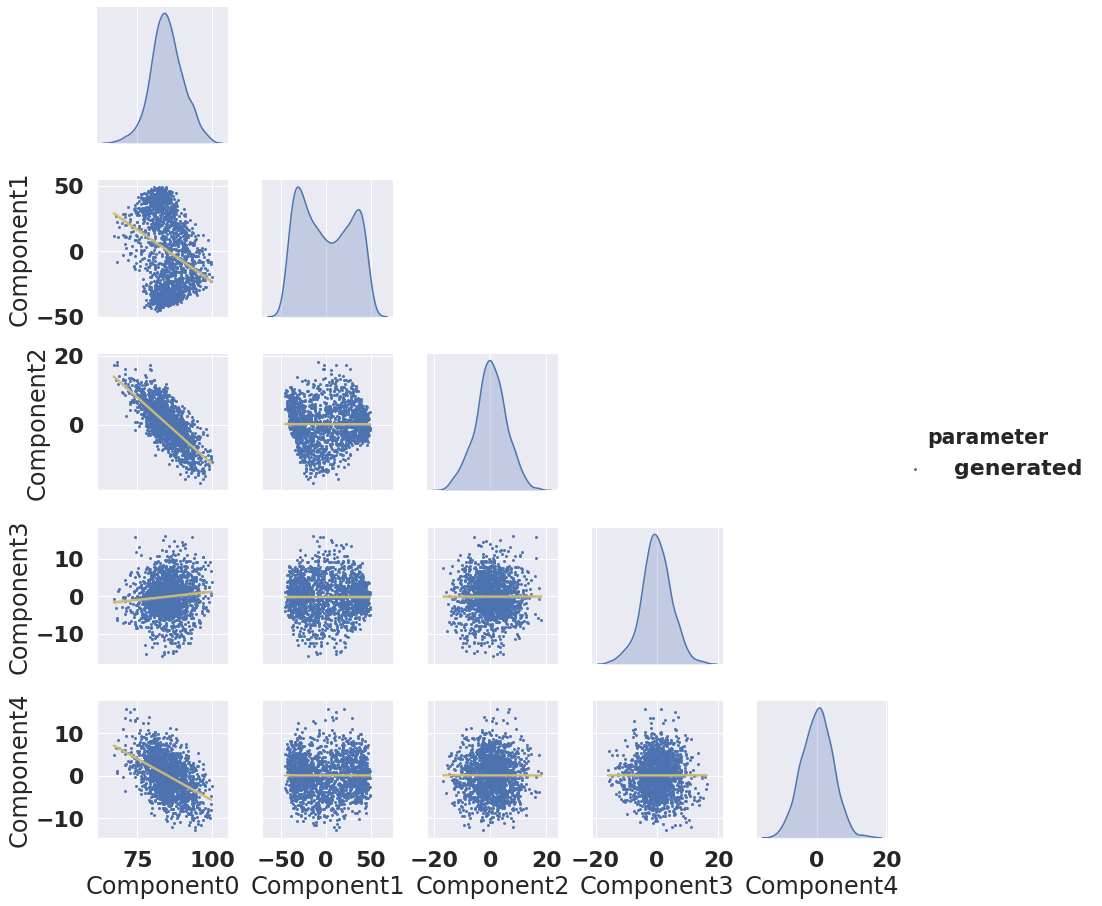

In [37]:
sns.set(font_scale = 2)

g = sns.pairplot(dfd, hue='parameter', markers='.', kind='reg', corner=True, palette=['g'],
                 plot_kws={'scatter_kws': {'alpha': 1.}, 'line_kws': {'color': 'darkgreen'}})

sns.pairplot(dfg, hue='parameter', markers='.', kind='reg', corner=True, palette=['b'],
                 plot_kws={'scatter_kws': {'alpha': 1.}, 'line_kws': {'color': 'y'}})
g.fig.subplots_adjust(top=0.95, wspace=0.1, hspace=0.1)
g.fig.suptitle(f'Spatial maps of SVD principal components derived from simulated and generated dataset.\n'
               , fontsize=25, fontweight='bold')

#plt.savefig('./fig_82c/SVD_on_data_and_generated_compo_proj_30y.pdf')


In [38]:
VT = svd.components_
VTg = svdg.components_
VT.shape

(5, 8192)

In [39]:
dp = np.dot(VT, VTg.T)

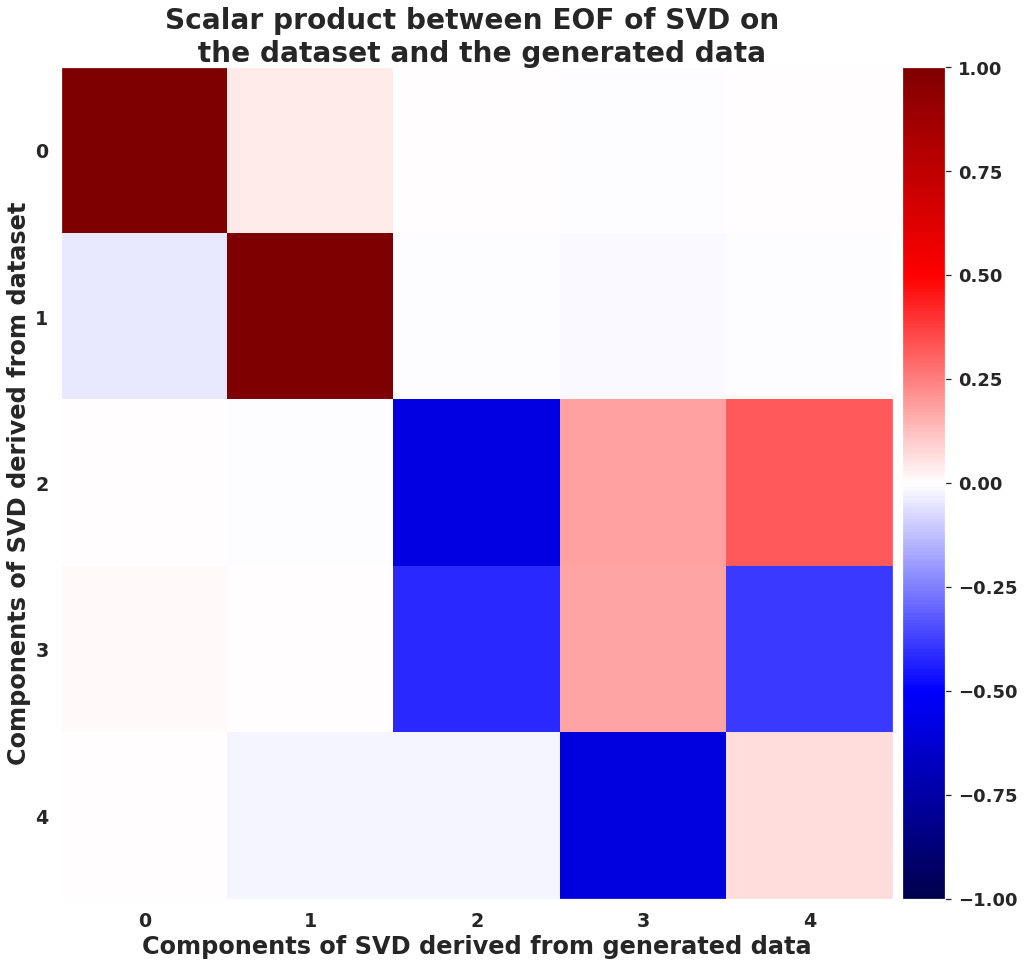

In [41]:
fig = plt.figure(figsize=(15,15))
axc = fig.add_subplot()
plt.subplots_adjust(top=0.95, right=0.87, left=0.1, hspace=0.1,bottom=0.01)
cim2 = plt.imshow(dp, cmap='seismic', vmin=-1, vmax=1)
#plt.colorbar()
plt.title('Scalar product between EOF of SVD on \n the dataset and the generated data', fontweight='bold', fontsize=28)
plt.xlabel('Components of SVD derived from generated data',  fontsize=24, fontweight='bold')
plt.ylabel('Components of SVD derived from dataset',  fontsize=24, fontweight='bold')
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.grid(False)
posn = axc.get_position()
cax22 = fig.add_axes([posn.x0+posn.width + 0.008, posn.y0, 0.04, posn.height])
cbar = plt.colorbar(cim2, cax = cax22)
cbar.ax.tick_params(labelsize=18)
#plt.savefig('./fig_82c/dp_eof.pdf')

In [42]:
print(fig)

Figure(1080x1080)


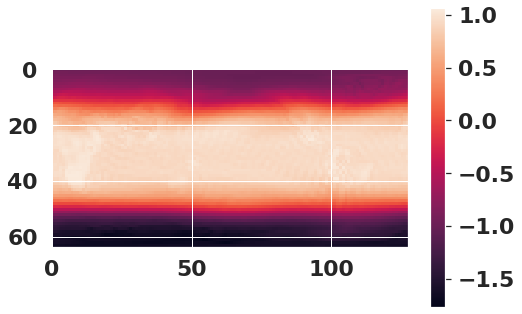

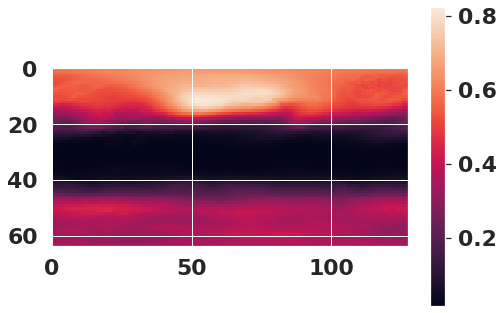

In [43]:
mX = np.mean(X, axis=0)
sX = np.std(X,axis=0)
plt.figure()
plt.imshow(mX)
plt.colorbar()
plt.figure()
plt.imshow(sX)
plt.colorbar()

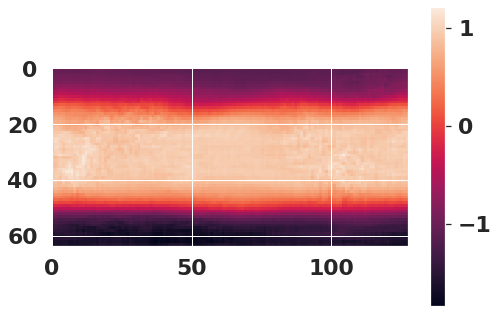

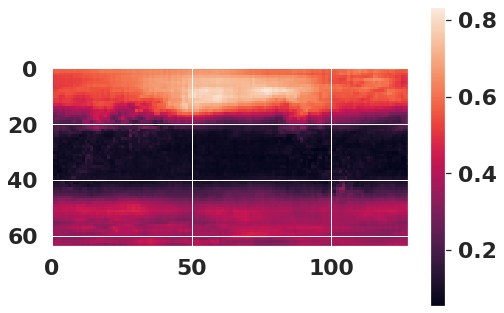

In [44]:
mXg = np.mean(Xg, axis=0)
sXg = np.std(Xg, axis=0)
plt.figure()
plt.imshow(mXg)
plt.colorbar()
plt.figure()
plt.imshow(sXg)
plt.colorbar()

[ 0.00533501  0.03446917  0.01493123  0.04885615  0.05154938  0.06662152
  0.05091206  0.04858699  0.06208293  0.05049726  0.04240368  0.03835375
  0.02324538  0.02438484  0.01742164  0.00505756  0.00260564  0.00581877
 -0.00167626  0.00963518  0.0208025   0.02823439  0.0359348   0.03632447
  0.02537831  0.0356952   0.03649505  0.03695599  0.03885636  0.05435474
  0.05180928  0.05333711  0.06102553  0.06586478  0.06627634  0.05678553
  0.06728238  0.05973462  0.0603524   0.05956873  0.05996929  0.06674163
  0.0649818   0.07670854  0.07009604  0.08209346  0.0823672   0.08376153
  0.09798386  0.09041756  0.09769423  0.10418928  0.11258708  0.1171735
  0.10872403  0.10886321  0.10683267  0.11125955  0.11205329  0.10754209
  0.10600085  0.10073464  0.09616854  0.09638879  0.09806078  0.10028698
  0.09527059  0.09906909  0.10369566  0.10838754  0.11026654  0.10185257
  0.11655615  0.10916412  0.1112772   0.11122134  0.11769677  0.11152661
  0.11394568  0.11249613  0.1091917   0.10765947  0.

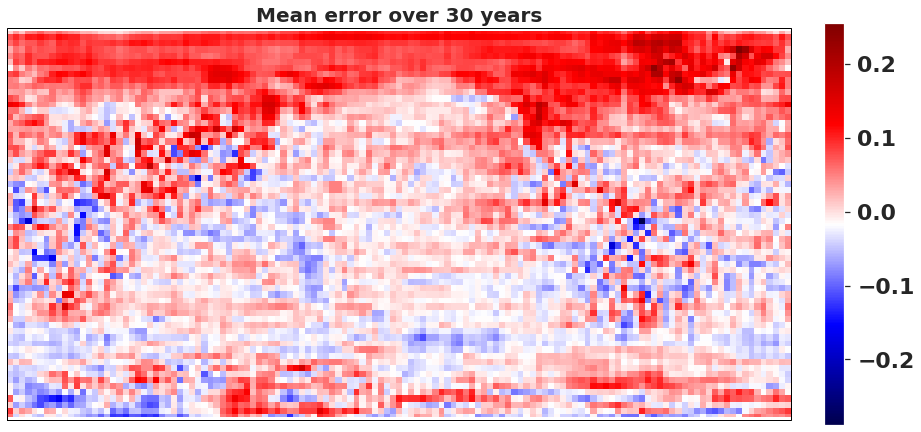

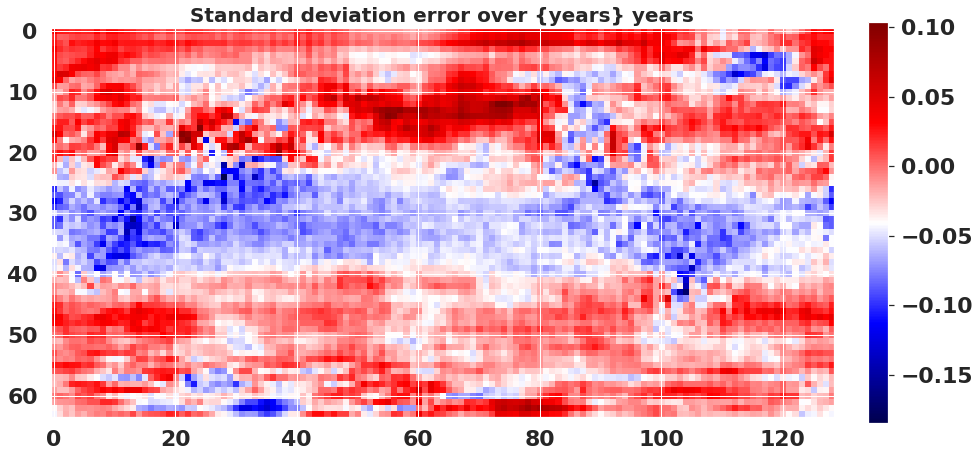

In [45]:
import cartopy.util

meanerr = cartopy.util.add_cyclic_point(mX-mXg, coord=lons, axis=1)[0]
print(meanerr[0])
stderr = cartopy.util.add_cyclic_point(sX-sXg, coord=lons, axis=1)[0]

import cartopy.crs as ccrs

plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
plt.title('Mean error over 30 years', fontsize=20, fontweight='bold')
im = plt.imshow(meanerr, cmap='seismic', transform=ccrs.PlateCarree(central_longitude=360.))
plt.colorbar(im, fraction=0.024, pad=0.04)
plt.figure(figsize=(15,15))
plt.title('Standard deviation error over {years} years', fontsize=20, fontweight='bold')
im = plt.imshow(stderr, cmap='seismic')
plt.colorbar(im, fraction=0.024, pad=0.04)

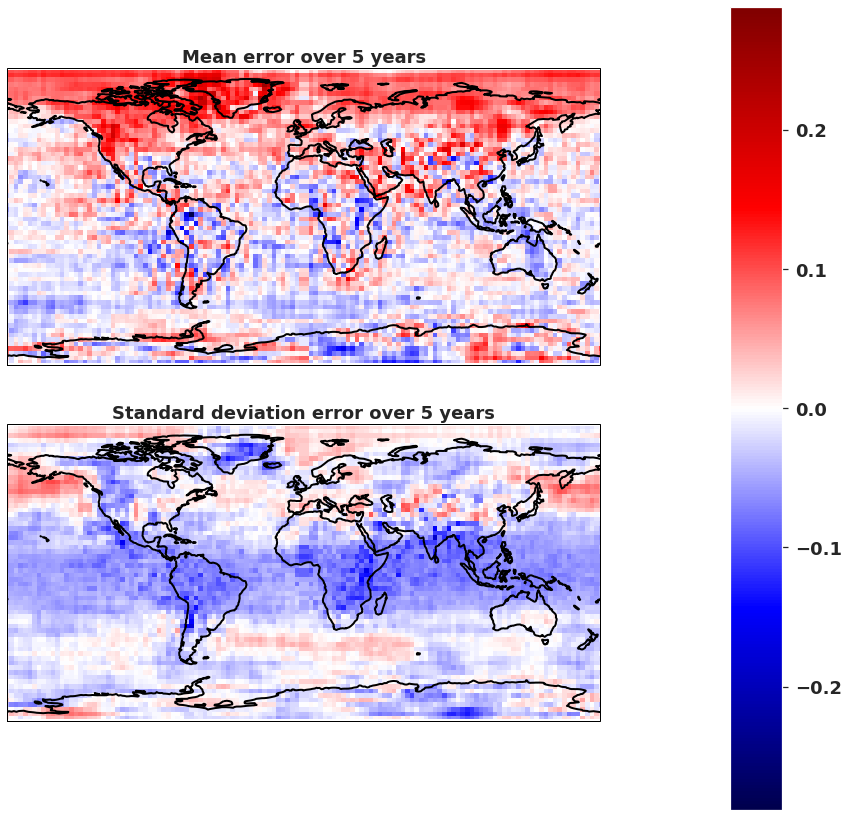

In [47]:
max_val = np.amax(np.asarray([np.abs(np.amin(mX-mXg)), np.abs(np.amax(mX-mXg)), np.abs(np.amax(mX-mXg)), np.abs(np.amin(mX-mXg)), 
                              np.abs(np.amin(sX-sXg)), np.abs(np.amax(sX-sXg)), np.abs(np.amax(sX-sXg)), np.abs(np.amin(sX-sXg))]))
fig, axs = plt.subplots(2,1, figsize=(24,12), subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
axs[0].coastlines(linewidth=2.)
ax = axs[0]
ax.grid(False)
ax.set_title(f'Mean error over {years} years', fontsize=18, fontweight='bold')
im1 = ax.imshow(meanerr[::-1,:], cmap='seismic', vmin=-max_val, vmax=max_val, transform=ccrs.PlateCarree(central_longitude=180.))
plt.axis('off')
posn0 = ax.get_position()
ax2 = axs[1]
axs[1].coastlines(linewidth=2.)
ax2.grid(False)
ax2.set_title(f'Standard deviation error over {years} years', fontsize=18, fontweight='bold')
im = ax2.imshow(stderr[::-1,:], vmin=-max_val, vmax=max_val, cmap='seismic', transform=ccrs.PlateCarree(central_longitude=180.))
plt.axis('off')
posn = ax2.get_position()
cax = fig.add_axes([posn.x1+0.075 , 0.022, 0.03, posn0.height*2+0.243])
cbar = plt.colorbar(im1, cax=cax)
cbar.ax.tick_params(labelsize=18)

#plt.savefig('./fig_82c/mean_std_climate_err.pdf')


In [ ]:
print(f'Notebook run in {time.time()-start} seconds for {N_gen} samples')